In [1]:
## import stuff

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import tensorflow as tf
import random
import matplotlib.pyplot as plt

%matplotlib inline
import os
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import gc 

In [2]:
gc.collect()

132

In [3]:
## import the tablular data info

data_train = pd.read_csv('~/Downloads/siim-isic-melanoma-classification/train.csv')
data_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
## sex and anatomical_Site categorical
data_train.sex = np.where(data_train.sex == 'female', 1, 0)
data_train = pd.get_dummies(data_train, columns = ['anatom_site_general_challenge'])
data_train.head()

,image_name,patient_id,sex,age_approx,diagnosis,benign_malignant,target,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper extremity
0,ISIC_2637011,IP_7279968,0,45.0,unknown,benign,0,1,0,0,0,0,0
1,ISIC_0015719,IP_3075186,1,45.0,unknown,benign,0,0,0,0,0,0,1
2,ISIC_0052212,IP_2842074,1,50.0,nevus,benign,0,0,1,0,0,0,0
3,ISIC_0068279,IP_6890425,1,45.0,unknown,benign,0,1,0,0,0,0,0
4,ISIC_0074268,IP_8723313,1,55.0,unknown,benign,0,0,0,0,0,0,1


## look at image data

In [5]:
os.chdir('../../Downloads/siim-isic-melanoma-classification/')
data_dir = 'jpeg/train/'
train_files = os.listdir(data_dir)

In [6]:
len(train_files)

33126

In [7]:
## dict of the image and its target
data_train.image_name = data_train.image_name.astype(str) + str('.jpg')
target_dict = pd.Series(data_train.target.values, index = data_train.image_name).to_dict()

In [8]:
## list of melanoma and not melanoma images
ls_melanoma = []
ls_no_melanoma = []
for k,v in target_dict.items():
    if v == 1:
        ls_melanoma.append(k)
    if v == 0:
        ls_no_melanoma.append(k)

In [9]:
random.choice(ls_no_melanoma)

'ISIC_7441191.jpg'

In [10]:
gc.collect()

60

## Body Hair Analysis - blackhat filter

In [30]:
def hair_remove(image):
    import cv2
    kernel = cv2.getStructuringElement(1,(15,15)) 
    # Reading the image named 'input.jpg' 
    #input_image = cv2.imread(image) 
    ## resize the image
    #image_resize = cv2.resize(input_image,(512,512))
    ## blacknwhite
    input_image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Applying the Black-Hat operation 
    tophat_img = cv2.morphologyEx(input_image_gray
                                  , cv2.MORPH_BLACKHAT
                                  , kernel)
    ## threshold the image to increase the hair intensity
    ret,thresh_img = cv2.threshold(tophat_img,10,255,cv2.THRESH_BINARY)
    ## remove it 
    pre_out = cv2.inpaint(image,thresh_img,1,cv2.INPAINT_TELEA)
    ## convert back to rgb 
    out = cv2.cvtColor(pre_out, cv2.COLOR_BGR2RGB)
    return out

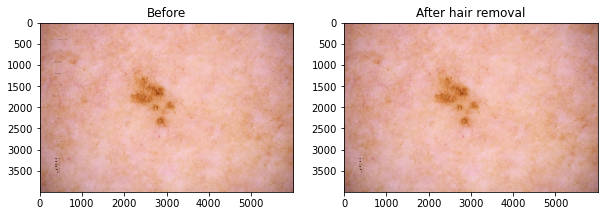

In [13]:
pic = os.path.join(data_dir, random.choice(ls_no_melanoma))
img = mpimg.imread(pic)
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Before')
plt.subplot(1, 2, 2)
plt.imshow(hair_remove(pic))
plt.title('After hair removal')
plt.show()

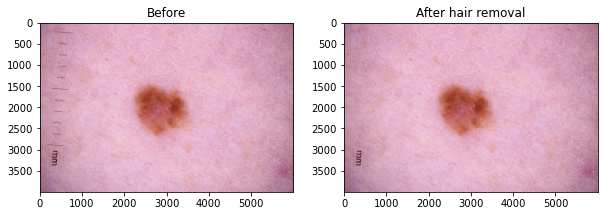

In [14]:
pic = os.path.join(data_dir, random.choice(ls_melanoma))
img = mpimg.imread(pic)
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Before')
plt.subplot(1, 2, 2)
plt.imshow(hair_remove(pic))
plt.title('After hair removal')
plt.show()

## Augmentation

- use image generator
- pass a custom augmentation func to remove hair in images 

In [15]:
## make new directory
! mkdir 'train_w_class'

mkdir: train_w_class: File exists


In [ ]:
## create class directories
! mkdir 'train_w_class/no_melanoma'
! mkdir 'train_w_class/melanoma'
melanoma_dir = 'train_w_class/melanoma'
no_melanoma_dir = 'train_w_class/no_melanoma'

In [ ]:
## move images to class specific directories

## creating no melanoma dir
for i in ls_no_melanoma:
    shutil.copy(os.path.join('jpeg/train/', i), os.path.join(no_melanoma_dir, i))
    

## creating melanoma dir
for i in ls_melanoma:
    shutil.copy(os.path.join('jpeg/train/', i), os.path.join(melanoma_dir, i))

## Image loading and Augmentation

In [33]:
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

## some additional data augmentation
training_datagen = ImageDataGenerator(
    rescale = 1./255
    , rotation_range=40
    , width_shift_range=0.2 
    , height_shift_range=0.2 
    , zoom_range=0.2
    , horizontal_flip=True
    , fill_mode='nearest'
#    , preprocessing_function=hair_remove
)

## utilize the new directory structure to infer classes
train_generator = training_datagen.flow_from_directory(
    'train_w_class'
    , target_size=(512,512)
    , class_mode='binary'
    , batch_size=100
)

Found 33126 images belonging to 2 classes.


## Transfer Learning model - Xception 

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50

transf_model = ResNet50(weights='imagenet'
                        , input_shape = (512,512,3)
                        , include_top = False)

for layer in transf_model.layers:
    layer.trainable = False
    
transf_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
## grab the last layer 
last_layer = transf_model.get_layer('conv5_block3_out')
print(last_layer.output_shape)

(None, 16, 16, 2048)


In [19]:
freeze_output = last_layer.output

In [20]:
## flatten - fully connected layer w/ dropout - output prediction
x = tf.keras.layers.Flatten()(freeze_output)
## add the sex, age and anatomical-site to the output of the resnet for further processing 
# FC layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# final layer for classification
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)  

In [35]:
model = tf.keras.Model(transf_model.input, x)
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(lr=0.0001)
              , loss = 'binary_crossentropy'
              , metrics = ['accuracy', tf.keras.metrics.AUC()])

In [44]:
history = model.fit(
    train_generator
    , steps_per_epoch = 100
    , epochs = 20
    , verbose = 1)

Epoch 1/20
100/100 [==============================] - 3209s 32s/step - loss: 1.2997 - accuracy: 0.9524 - auc_2: 0.4934
Epoch 2/20
100/100 [==============================] - 3104s 31s/step - loss: 0.7760 - accuracy: 0.9545 - auc_2: 0.5022
Epoch 3/20
100/100 [==============================] - 3083s 31s/step - loss: 0.6544 - accuracy: 0.9541 - auc_2: 0.4858
Epoch 4/20
100/100 [==============================] - 3066s 31s/step - loss: 0.3293 - accuracy: 0.9672 - auc_2: 0.5212
Epoch 5/20
100/100 [==============================] - 3072s 31s/step - loss: 0.1657 - accuracy: 0.9786 - auc_2: 0.4801
Epoch 6/20
100/100 [==============================] - 3044s 30s/step - loss: 0.0970 - accuracy: 0.9837 - auc_2: 0.5292
Epoch 7/20
100/100 [==============================] - 3067s 31s/step - loss: 0.1063 - accuracy: 0.9809 - auc_2: 0.4927
Epoch 8/20
100/100 [==============================] - 3049s 30s/step - loss: 0.1047 - accuracy: 0.9807 - auc_2: 0.5270
Epoch 9/20
100/100 [============================

In [43]:
config =  tf.compat.v1.ConfigProto(device_count={"CPU": 12},
                                   inter_op_parallelism_threads=1,
                                   intra_op_parallelism_threads=1)
sess = tf.compat.v1.Session(config=config)

## Testing
- preprocess the test images
    - resize
- predict and create a submission csv

In [53]:
## move test images one level deeper
test_imgs = (os.listdir('jpeg/test'))
! mkdir 'test_flow'
! mkdir 'test_flow/test'

## moving
for i in test_imgs:
    shutil.copy(os.path.join('jpeg/test', i), os.path.join('test_flow/test', i))

In [55]:
test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    'test_flow'
    , target_size=(512,512)
    , class_mode=None
    , batch_size=50
    , shuffle = False
)

Found 10982 images belonging to 1 classes.


In [59]:
## alright lets use this to predict probabilities
pred=model.predict_generator(test_generator,verbose=1)

220/220 [==============================] - 2737s 12s/step


In [57]:
submission = pd.DataFrame({'image_name':test_imgs
                           , 'target':pred.reshape(10982,)})

submission['image_name'] = submission['image_name'].str.replace('.jpg','')
submission.head()

,image_name,target
0,ISIC_6825769,0.999613
1,ISIC_3711637,0.997990
2,ISIC_6290714,0.998142
3,ISIC_8562507,0.998174
4,ISIC_8558857,0.998066


In [58]:
submission.to_csv('submission_sample_transfer_learning_model.csv', index = False)